<a href="https://colab.research.google.com/github/lise1905/mini_project/blob/main/cloth_recom_direct_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [1]:
#!pip install anvil-uplink

     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 51 kB 160 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=df84bb1dc43e60090ff6a51814f22a4f8ee1b3fefc14187a70a9f28c6afb45d6
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [2]:
#import anvil.server

In [3]:
#anvil.server.connect("7RJFIBTRQEAO5V264Q4MOWNY-RQVFY27EZYQHNA7K")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [3]:
#pip install flask-ngrok

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Colab Notebooks/mini_project

/content/drive/MyDrive/Colab Notebooks/mini_project


In [7]:
df = pd.read_excel('dataset_cloth_recom.xlsx')

In [8]:
print(df.head(10))

   fit  user_id bust size  item_id  weight  ...  category height  size    age product
0  fit   420272       34d  2260466  137lbs  ...    romper  5' 8"  14.0   28.0   1.jpg
1  fit   273551       34b   153475  132lbs  ...      gown  5' 6"  12.0   36.0   2.jpg
2  fit   360448       NaN  1063761     NaN  ...    sheath  5' 4"   4.0  116.0  15.jpg
3  fit   909926       34c   126335  135lbs  ...     dress  5' 5"   8.0   34.0   4.jpg
4  fit   151944       34b   616682  145lbs  ...      gown  5' 9"  12.0   27.0   5.jpg
5  fit   734848       32b   364092  138lbs  ...     dress  5' 8"   8.0   45.0   6.jpg
6  fit   336066       34c   568429  112lbs  ...     dress  5' 3"   4.0   27.0   7.jpg
7  fit    86661      34d+   130259  118lbs  ...     dress  5' 3"   8.0   65.0   8.jpg
8  fit   166228       36d  1729232     NaN  ...      gown  5' 6"  21.0   27.0   9.jpg
9  fit   126461       36c   132135  129lbs  ...      gown  5' 6"   7.0   20.0  10.jpg

[10 rows x 15 columns]


In [9]:
data=df.drop(['review_text','review_summary'],axis = 1)

In [10]:
data.dtypes

fit            object
user_id         int64
bust size      object
item_id         int64
weight         object
rating          int64
rented for     object
body type      object
category       object
height         object
size          float64
age           float64
product        object
dtype: object

In [11]:
print(data.head(10))

   fit  user_id bust size  item_id  weight  ...  category height  size    age product
0  fit   420272       34d  2260466  137lbs  ...    romper  5' 8"  14.0   28.0   1.jpg
1  fit   273551       34b   153475  132lbs  ...      gown  5' 6"  12.0   36.0   2.jpg
2  fit   360448       NaN  1063761     NaN  ...    sheath  5' 4"   4.0  116.0  15.jpg
3  fit   909926       34c   126335  135lbs  ...     dress  5' 5"   8.0   34.0   4.jpg
4  fit   151944       34b   616682  145lbs  ...      gown  5' 9"  12.0   27.0   5.jpg
5  fit   734848       32b   364092  138lbs  ...     dress  5' 8"   8.0   45.0   6.jpg
6  fit   336066       34c   568429  112lbs  ...     dress  5' 3"   4.0   27.0   7.jpg
7  fit    86661      34d+   130259  118lbs  ...     dress  5' 3"   8.0   65.0   8.jpg
8  fit   166228       36d  1729232     NaN  ...      gown  5' 6"  21.0   27.0   9.jpg
9  fit   126461       36c   132135  129lbs  ...      gown  5' 6"   7.0   20.0  10.jpg

[10 rows x 13 columns]


In [12]:
pip install surprise

     |████████████████████████████████| 11.8 MB 4.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630208 sha256=51b426de1c15d5f2970acc7f739f8a77fdb7cc83774b3d027b1abdaa87ddd21d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [13]:
from surprise import Dataset
from surprise import Reader
import os, io
from surprise import SVD
from surprise import accuracy

In [14]:
train, test = train_test_split(data, test_size=0.2)

In [15]:
def preprocessAge(data):
  bins = pd.IntervalIndex.from_tuples([(5, 15), (15, 30), (30, 50),(50,65),(65,100)])
  x = pd.cut(data['age'].to_list(), bins)
  x.categories = ['1','2','3','4','5']
  data['age_bins']  = x
  age_Preprocessed_data = data[~data['age_bins'].isnull()]
  # print ('{0} rows got dropped after age preprocessing'.format(str(data.shape[0] - age_Preprocessed_data.shape[0])))
  return age_Preprocessed_data

In [16]:
def preprocessBustsize(age_Preprocessed_data):
  data_bust_size_not_null = age_Preprocessed_data[~age_Preprocessed_data['bust size'].isnull()]
  data_bust_size_not_null['bust size'] = data_bust_size_not_null['bust size'].apply(lambda x : (int(x[:2]), x[2:]))
  data_bust_size_not_null.shape
  data_bust_size_not_null[['bust Size1', 'bust']] = pd.DataFrame(data_bust_size_not_null['bust size'].tolist(), index=data_bust_size_not_null.index)
  bustDict = {'a': 1, 'aa': 1, 'b': 2, 'c': 3, 'd': 4, 
            'd+': 5, 'dd': 5, 'ddd/e': 6,
           'f':7 , 'g': 8, 'h': 9, 'i': 10, 'j': 11}
  data_bust_size_not_null['bust1'] = data_bust_size_not_null['bust'].map(bustDict)
  # Calculating model of bust size based on age grp.
  def funct(df):
    return df.mode()
  x = data_bust_size_not_null[['age_bins','bust Size1','bust1']].groupby('age_bins').apply(funct)
  x.reset_index(inplace= True, drop = True)
  data_bust_size_null = age_Preprocessed_data[age_Preprocessed_data['bust size'].isnull()]
  data_bust_size_null = pd.merge(data_bust_size_null, x, how ='left', left_on = 'age_bins', right_on = 'age_bins')
  data_bust_size_cleansed = data_bust_size_not_null.append(data_bust_size_null)
  return data_bust_size_cleansed

In [17]:
def preprocessHeight(data_bust_size_cleansed):
  data_bust_size_cleansed['heightCM'] = data_bust_size_cleansed['height'].apply(lambda x : (int(x.split("\'")[0]) * 30.48) + (int(x.split("\'")[1][:-1]) * 2.54) 
                                                        if type(x) == str else x)
  data_bust_size_cleansed['heightCM'].fillna((data_bust_size_cleansed['heightCM'].mean()), inplace=True)
  return data_bust_size_cleansed

In [18]:
def preprocessWeight(data_bust_size_cleansed):
  data_bust_size_cleansed['weightLbs'] = data_bust_size_cleansed['weight'].apply(lambda x : int(x[:-3])                                                        if type(x) == str else x)
  data_bust_size_cleansed['weightLbs'].fillna((data_bust_size_cleansed['weightLbs'].mean()), inplace=True)
  return data_bust_size_cleansed

In [19]:
def preprocessRentedFor(data_bust_size_cleansed):
  data_bust_size_cleansed['rented for'].fillna('other', inplace=True)
  return data_bust_size_cleansed

In [20]:
def preprocessBodytype(data_bust_size_cleansed):
  # Calculating model of body type based on Bust Size.
  data_body_type_not_null = data_bust_size_cleansed[~data_bust_size_cleansed['body type'].isnull()]
  def func(df):
    return df.mode()
  x = data_body_type_not_null[['bust Size1','body type']].groupby('bust Size1').apply(func)
  x.reset_index(inplace= True, drop = True)
  # print(x)
  data_body_type_null = data_bust_size_cleansed[data_bust_size_cleansed['body type'].isnull()]
  data_body_type_null = pd.merge(data_body_type_null, x, how ='left', left_on = 'bust Size1', right_on = 'bust Size1')
  # print(data_body_type_null)
  data_body_type_cleansed = data_body_type_not_null.append(data_body_type_null,sort=True)
  # print(data_body_type_cleansed)
  data_body_type_cleansed['body type'].fillna(data_body_type_cleansed['body type_y'], inplace=True)
  del data_body_type_cleansed['body type_x']
  del data_body_type_cleansed['body type_y']
  return data_body_type_cleansed

In [21]:
def createFinalDataframe(cleansedData):
  final_df=cleansedData.copy()
  final_df=final_df.drop(['rented for','rating','category','age_bins','bust','bust size','fit','height','item_id','user_id','weight'],axis=1)
  cleanup_nums = {"body type":     {"hourglass": 1, "straight & narrow": 2, "pear": 3,"athletic": 4, "full bust": 5,"petite": 6, "apple": 7}}
  final_df.replace(cleanup_nums, inplace=True)
  return final_df

In [22]:
def createFinalTestDataframe(cleansedData):
  final_df=cleansedData.copy()
  final_df=final_df.drop(['rating','category','age_bins','bust','bust size','fit','height','item_id','weight'],axis=1)
  cleanup_nums = {"body type":     {"hourglass": 1, "straight & narrow": 2, "pear": 3,"athletic": 4, "full bust": 5,"petite": 6, "apple": 7}}
  final_df.replace(cleanup_nums, inplace=True)
  return final_df

In [23]:
age_Preprocessed_data=preprocessAge(train)
data_bust_size_cleansed=preprocessBustsize(age_Preprocessed_data)
data_bust_size_cleansed=preprocessHeight(data_bust_size_cleansed)
data_bust_size_cleansed=preprocessWeight(data_bust_size_cleansed)
data_bust_size_cleansed=preprocessRentedFor(data_bust_size_cleansed)
cleansedData=preprocessBodytype(data_bust_size_cleansed)
final_df=createFinalDataframe(cleansedData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [24]:
feature_names = ['age', 'bust Size1','bust1','size','heightCM','weightLbs']
X = final_df[feature_names]
y = final_df['body type']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [25]:
print(X)

     age  bust Size1  bust1  size  heightCM  weightLbs
70  36.0        32.0      3  16.0    180.34      140.0
53  33.0        36.0      4  16.0    165.10      190.0
89  48.0        34.0      3  24.0    172.72      138.0
55  32.0        34.0      3   8.0    170.18      140.0
35  52.0        38.0      3  16.0    165.10      145.0
..   ...         ...    ...   ...       ...        ...
1   33.0        36.0      3  12.0    165.10      145.0
2   29.0        36.0      5  28.0    160.02      138.6
3   36.0        32.0      4   8.0    167.64      138.6
4   35.0        34.0      3  24.0    165.10      165.0
5   32.0        34.0      3   1.0    160.02      115.0

[82 rows x 6 columns]


In [26]:
print(y)

70    4
53    4
89    2
55    1
35    4
     ..
1     1
2     1
3     4
4     1
5     1
Name: body type, Length: 82, dtype: int64


In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy of Random forest classifier on training set: {:.2f}'
    .format(model.score(X_train, y_train)))
print('Accuracy of Random forest classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))


              precision    recall  f1-score   support

           1       0.17      0.33      0.22         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         3
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         1

    accuracy                           0.14        21
   macro avg       0.10      0.19      0.13        21
weighted avg       0.07      0.14      0.10        21

Accuracy of Random forest classifier on training set: 1.00
Accuracy of Random forest classifier on test set: 0.14


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
'''
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred1 = knn.predict(X_test)
#print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

'''

              precision    recall  f1-score   support

           1       0.23      0.60      0.33         5
           2       0.33      0.25      0.29         4
           3       0.50      0.50      0.50         2
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0

    accuracy                           0.24        21
   macro avg       0.15      0.19      0.16        21
weighted avg       0.17      0.24      0.18        21

Accuracy of K-NN classifier on training set: 0.46
Accuracy of K-NN classifier on test set: 0.24


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [28]:
age_Preprocessed_testdata=preprocessAge(test)
testdata_bust_size_cleansed=preprocessBustsize(age_Preprocessed_testdata)
testdata_bust_size_cleansed=preprocessHeight(testdata_bust_size_cleansed)
testdata_bust_size_cleansed=preprocessWeight(testdata_bust_size_cleansed)
testdata_bust_size_cleansed=preprocessRentedFor(testdata_bust_size_cleansed)
cleansedTestData=preprocessBodytype(testdata_bust_size_cleansed)
final_test_df=createFinalTestDataframe(cleansedTestData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [29]:
feature_names = ['age', 'bust Size1','bust1','size','heightCM','weightLbs','rented for','user_id']
testdata = final_test_df[feature_names]

In [30]:
for col in testdata.columns:
    print(col)

age
bust Size1
bust1
size
heightCM
weightLbs
rented for
user_id


In [31]:
print(testdata)

      age  bust Size1  bust1  size  heightCM   weightLbs rented for  user_id
100  28.0        34.0    4.0  16.0    154.94  145.000000    wedding   387681
61   34.0        34.0    2.0   8.0    165.10  143.555556      party   242517
68   29.0        36.0    2.0   8.0    152.40  143.555556    wedding   324412
26   31.0        32.0    3.0   4.0    152.40  110.000000      party   462921
78   40.0        32.0    2.0   8.0    165.10  125.000000      party   456500
51   32.0        34.0    2.0   4.0    162.56  112.000000      party   145159
86   31.0        34.0    2.0  17.0    167.64  130.000000    wedding   220030
37   32.0        38.0    4.0  39.0    172.72  215.000000      other   518720
80   32.0        36.0    4.0  16.0    160.02  151.000000    wedding   588841
65   37.0        32.0    4.0  16.0    165.10  150.000000      party   991757
28   28.0        34.0    1.0  16.0    172.72  155.000000       date   430607
34   87.0        34.0    4.0  16.0    172.72  150.000000    wedding   286197

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
#%cd ..

In [33]:
print(final_df)

     age  body type  bust Size1  bust1  heightCM  product  size  weightLbs
70  36.0          4        32.0      3    180.34   58.jpg  16.0      140.0
53  33.0          4        36.0      4    165.10  324.jpg  16.0      190.0
89  48.0          2        34.0      3    172.72  137.jpg  24.0      138.0
55  32.0          1        34.0      3    170.18   85.jpg   8.0      140.0
35  52.0          4        38.0      3    165.10   79.jpg  16.0      145.0
..   ...        ...         ...    ...       ...      ...   ...        ...
1   33.0          1        36.0      3    165.10  126.jpg  12.0      145.0
2   29.0          1        36.0      5    160.02  733.jpg  28.0      138.6
3   36.0          4        32.0      4    167.64   43.jpg   8.0      138.6
4   35.0          1        34.0      3    165.10  671.jpg  24.0      165.0
5   32.0          1        34.0      3    160.02  149.jpg   1.0      115.0

[82 rows x 8 columns]


Enter age:22
Enter bust size:22
Enter cup size:22
Enter size:222
Enter height cm:222
Enter weight lbs:122
Enter occasion:date


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Predicted body type: ['hourglass']
Recommended itemID: 1146825.0
Recommended category: dress
Occasion: date
Recommended product: 671.jpg


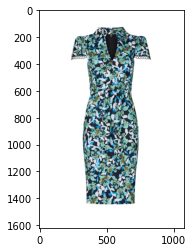

In [38]:
#cf_df=[]
age = input("Enter age:")
bustSize1 = input("Enter bust size:")
bust1 = input("Enter cup size:")#bust size-band size
size = input("Enter size:")#dress size
heightCM = input("Enter height cm:")
weightLbs = input("Enter weight lbs:")
rented_for = input("Enter occasion:")
    
xnew=[[age,bustSize1,bust1,size,heightCM,weightLbs]]
bodytypenumber=model.predict(xnew)

bodytypearray=["NaN","hourglass", "straight & narrow", "pear","athletic", "full bust","petite", "apple"]
bodytype=np.asanyarray(bodytypearray)[bodytypenumber]
print("Predicted body type:",bodytype)#print body type
    
cluster_df=cleansedData.copy()
groupedbybodytype = cluster_df.groupby('body type')
for name,group in groupedbybodytype:
  if(bodytype==name):
    grouped_df=group.copy()
  rentedFor=rented_for

groupedbybodytype = grouped_df.groupby('rented for')
for name,group in groupedbybodytype:
  if(rentedFor==name):
    cf_df=group.copy()
cf_df=cf_df[['user_id','item_id','rating']].copy()
    
reader = Reader(rating_scale=(1,10))
traindata=Dataset.load_from_df(cf_df,reader)
trainingSet = traindata.build_full_trainset()
    
svdAlgo = SVD(n_factors=200,n_epochs=50)
svdAlgo.fit(trainingSet)
    
itemid=cf_df['item_id'].unique()
ratingOutput = pd.DataFrame(columns=['item_id', 'rating']) #Create a blank df with 2 columns at first and then append data
    
for i in range(len(itemid)):
  user=cf_df.iloc[i,0] #User_id
  item=cf_df.iloc[i,1] #Item_id
  output=svdAlgo.predict(user,item,r_ui=None,clip=True,verbose=False)
  ratingOutput = ratingOutput.append({'item_id': item, 'rating': output.est}, ignore_index=True)
        
ratingOutput=ratingOutput.sort_values('rating',ascending=False)
outputdf=ratingOutput.head(10).copy()
    #print("Top 10 recommended items with their predicted ratings:")
    #outputdf.head()
rawdf = pd.read_excel("dataset_cloth_recom.xlsx")
itemID=outputdf['item_id'].iloc[0]#.astype('int64')
print("Recommended itemID:",itemID)
finaldf = (rawdf[rawdf['item_id']==itemID].iloc[0])
print("Recommended category:",finaldf['category'])
finalpro = (rawdf[rawdf['item_id']==itemID].iloc[0])
print("Occasion:",finaldf['rented for'])
print("Recommended product:",finaldf['product'])
plt.imshow(mpimg.imread(finaldf['product']))
    


In [41]:
'''
@anvil.server.callable
def predict(age,bustSize1,bust1,size,heightCM,weightLbs):
  classification = model.predict([[age,bustSize1,size,heightCM,weightLbs]])
  return classification
'''

'\n@anvil.server.callable\ndef predict(age,bustSize1,bust1,size,heightCM,weightLbs):\n  classification = model.predict([[age,bustSize1,size,heightCM,weightLbs]])\n  return classification\n'

In [40]:
#anvil.server.wait_forever()

KeyboardInterrupt: ignored